In [1]:
import numpy as np
import xarray as xr

from bokeh.models import Range1d, LinearAxis
from bokeh.plotting import figure, show
from bokeh.palettes import Colorblind as palette
from bokeh.io import output_notebook

import warnings
warnings.filterwarnings('ignore')

In [2]:
ADCPfile = 'deployment0004_RS01SLBS-LJ01A-10-ADCPTE101-streamed-adcp_velocity_beam_20190815T000000.905422-20190821T235959.790731.nc'

ds = xr.open_dataset(ADCPfile).load()  # download the data first, before converting
ds = ds.swap_dims({'obs': 'time'})

# resample the burst data data into median averaged bursts -- make it a little easier to work with
ds = ds.reset_coords()
bursts = ds.resample(time='5Min').median()
    
# reset the attributes.
bursts.attrs = ds.attrs
for v in bursts.variables:
    bursts[v].attrs = ds[v].attrs

adcp = bursts

In [3]:
adcp

<xarray.Dataset>
Dimensions:                         (bin: 50, time: 2016)
Coordinates:
  * time                            (time) datetime64[ns] 2019-08-15 ...
Dimensions without coordinates: bin
Data variables:
    obs                             (time) float64 122.0 367.0 612.0 857.5 ...
    deployment                      (time) float64 4.0 4.0 4.0 4.0 4.0 4.0 ...
    bin_1_distance                  (time) float64 1.237e+03 1.237e+03 ...
    cell_length                     (time) float64 800.0 800.0 800.0 800.0 ...
    correlation_magnitude_beam1     (time, bin) float64 121.0 126.0 128.0 ...
    correlation_magnitude_beam2     (time, bin) float64 120.0 128.0 129.0 ...
    correlation_magnitude_beam3     (time, bin) float64 123.0 128.0 127.0 ...
    correlation_magnitude_beam4     (time, bin) float64 8.0 7.0 7.0 7.0 7.0 ...
    echo_intensity_beam1            (time, bin) float64 110.0 107.0 103.0 ...
    echo_intensity_beam2            (time, bin) float64 106.0 105.0 99.0 ...
    ec

In [4]:
# pull in the needed ion_functions modules
from ion_functions.data.generic_functions import magnetic_declination, replace_fill_with_nan
from ion_functions.data.adcp_functions import ADCP_FILLVALUE, magnetic_correction, adcp_ins2earth

In [5]:
# create an updated beam2ins function that will compute a 3-beam solution.
def adcp_beam_earth(b1, b2, b3, b4, pg1, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt):
    """
    Instead of using the individual wrapper functions outlined in the adcp_functions module
    for the eastward, northward, vertical and error velocities, I've combined them into a
    single function.
    """
    # force shapes of some inputs to arrays of the correct dimensions
    lat = np.atleast_1d(lat)
    lon = np.atleast_1d(lon)
    dt = np.atleast_1d(dt)

    # compute the beam to instrument transform
    x, y, z, e = adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4)

    # compute the instrument to earth beam transform
    u, v, w = adcp_ins2earth(x, y, z, h, p, r, vf)

    # compute the magnetic variation, and ...
    theta = magnetic_declination(lat, lon, dt)

    # ... correct for it
    u_cor, v_cor = magnetic_correction(theta, u, v)

    # scale velocity from mm/s to m/s
    u_cor = u_cor / 1000.
    v_cor = v_cor / 1000.
    w = w / 1000.
    e = e / 1000.
    
    # return the velocity profiles
    return u_cor, v_cor, w, e

def adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4):
    """
    Description:
        This function converts the Beam Coordinate transformed velocity
        profiles to the instrument coordinate system. The calculations are
        defined in the Data Product Specification for Velocity Profile and Echo
        Intensity - DCN 1341-00750.
    Implemented by:
        2013-04-10: Christopher Wingard. Initial code.
        2015-06-24: Russell Desiderio. Incorporated int fillvalue -> Nan.
        2019-08-13: Christopher Wingard. Adds functionality to compute a 3-beam solution
                    and cleans up syntax used in the function.
    Usage:
        x, y, z, e = adcp_beam2ins(b1, b2, b3, b4, pg1, pg2, pg3, pg4)
            where
        x = x axis velocity profiles in instrument coordinates [mm s-1]
        y = y axis velocity profiles in instrument coordinates [mm s-1]
        z = z axis velocity profiles in instrument coordinates [mm s-1]
        e = error velocity profiles [mm s-1]
        b1 = beam 1 velocity profiles in beam coordinates [mm s-1]
        b2 = beam 2 velocity profiles in beam coordinates [mm s-1]
        b3 = beam 3 velocity profiles in beam coordinates [mm s-1]
        b4 = beam 4 velocity profiles in beam coordinates [mm s-1]
        pg1 = percent good estimate for beam 1 [percent]
        pg2 = percent good estimate for beam 2 [percent]
        pg3 = percent good estimate for beam 3 [percent]
        pg4 = percent good estimate for beam 4 [percent]
    References:
        OOI (2012). Data Product Specification for Velocity Profile and Echo Intensity. Document Control Number
            1341-00750. https://alfresco.oceanobservatories.org/ (See: Company Home >> OOI >> Cyberinfrastructure >>
            Data Product Specifications >> 1341-00750_Data_Product_SPEC_VELPROF_ECHOINT_OOI.pdf)
        OOI (2013). Data Product Specification for Turbulent Velocity Profile and Echo Intensity. Document Control
            Number 1341-00760. https://alfresco.oceanobservatories.org/ (See: Company Home >> OOI >>
            Cyberinfrastructure >> Data Product Specifications >>  1341-00760_Data_Product_VELTURB_ECHOINT.pdf)
        Teledyne RD Instruments (2008). ADCP Coordinate Transformation, Formulas and Calculations.
    """
    # raw beam velocities, set to correct shape
    b1 = np.atleast_2d(b1)
    b2 = np.atleast_2d(b2)
    b3 = np.atleast_2d(b3)
    b4 = np.atleast_2d(b4)

    # percentage of good pings for each beam per depth cell, set to correct shape
    pg1 = np.atleast_2d(pg1)
    pg2 = np.atleast_2d(pg2)
    pg3 = np.atleast_2d(pg3)
    pg4 = np.atleast_2d(pg4)

    # using the vendor specified percent good floor of 25%, create masked arrays with fill values set to compute
    # a 3-beam solution, if applicable.
    ma1 = np.ma.masked_where(pg1 < 25, b1)
    bm1 = ma1.filled((b2 - b3 - b4) * -1)
    ma2 = np.ma.masked_where(pg2 < 25, b2)
    bm2 = ma2.filled((b1 - b3 - b4) * -1)
    ma3 = np.ma.masked_where(pg3 < 25, b3)
    bm3 = ma3.filled(b1 + b2 - b4)
    ma4 = np.ma.masked_where(pg4 < 25, b4)
    bm4 = ma4.filled(b1 + b2 - b3)

    # sum across the masked arrays to determine if more than 1 beam is bad per depth cell, if so we cannot compute a
    # 3-beam solution and need to set the fill value to a NaN.
    mad = np.ma.dstack((ma1, ma2, ma3, ma4))    # stack the masked arrays in depth
    mas = np.ma.count_masked(mad, axis=2)       # count the number of depth cells masked in the depth stacked array

    # using the above, reset the raw beams. fill with 3-beam if applicable, otherwise use a NaN
    bm1 = np.ma.filled(np.ma.masked_where(mas > 1, bm1), ADCP_FILLVALUE)
    bm2 = np.ma.filled(np.ma.masked_where(mas > 1, bm2), ADCP_FILLVALUE)
    bm3 = np.ma.filled(np.ma.masked_where(mas > 1, bm3), ADCP_FILLVALUE)
    bm4 = np.ma.filled(np.ma.masked_where(mas > 1, bm4), ADCP_FILLVALUE)

    bm1, bm2, bm3, bm4 = replace_fill_with_nan(ADCP_FILLVALUE, bm1, bm2, bm3, bm4)

    theta = 20.0 / 180.0 * np.pi
    a = 1.0 / (2.0 * np.sin(theta))
    b = 1.0 / (4.0 * np.cos(theta))
    c = 1.0   # +1.0 for convex transducer head, -1 for concave
    d = a / np.sqrt(2.0)

    x = c * a * (bm1 - bm2)
    y = c * a * (bm4 - bm3)
    z = b * (bm1 + bm2 + bm3 + bm4)
    e = d * (bm1 + bm2 - bm3 - bm4)

    return x, y, z, e

In [6]:
# setup the inputs
b1 = adcp.velocity_beam1.values  # reported as a float, convert back to integer with proper fill value
b1 = np.ma.filled(np.ma.masked_where(np.isnan(b1), b1), ADCP_FILLVALUE).astype('int')
b2 = adcp.velocity_beam2.values  # reported as a float, convert back to integer with proper fill value
b2 = np.ma.filled(np.ma.masked_where(np.isnan(b2), b2), ADCP_FILLVALUE).astype('int')
b3 = adcp.velocity_beam3.values  # reported as a float, convert back to integer with proper fill value
b3 = np.ma.filled(np.ma.masked_where(np.isnan(b3), b3), ADCP_FILLVALUE).astype('int')
b4 = adcp.velocity_beam4.values  # reported as a float, convert back to integer with proper fill value
b4 = np.ma.filled(np.ma.masked_where(np.isnan(b4), b4), ADCP_FILLVALUE).astype('int')
pg1 = adcp.percent_good_beam1.values
pg2 = adcp.percent_good_beam2.values
pg3 = adcp.percent_good_beam3.values
pg4 = adcp.percent_good_beam4.values
h = adcp.heading.values
p = adcp.pitch.values
r = adcp['roll'].values
vf = adcp.sysconfig_vertical_orientation.values
lat = 44.51519
lon = -125.38987
dt = adcp.time.values.astype(float) / 10.0**9
bin_depth = adcp.bin_depths.values

In [7]:
# calculate the velocity profiles with the newer 3-beam solution algorithm
u_cor, v_cor, w, e = adcp_beam_earth(b1, b2, b3, b4, pg1, pg2, pg3, pg4, h, p, r, vf, lat, lon, dt)

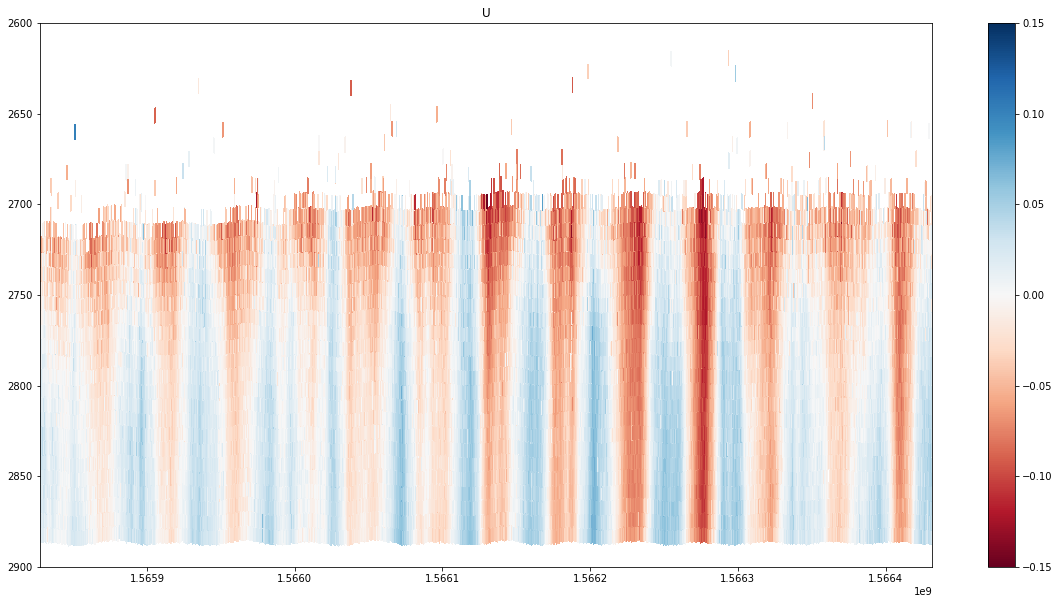

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, u_cor.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('U')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()

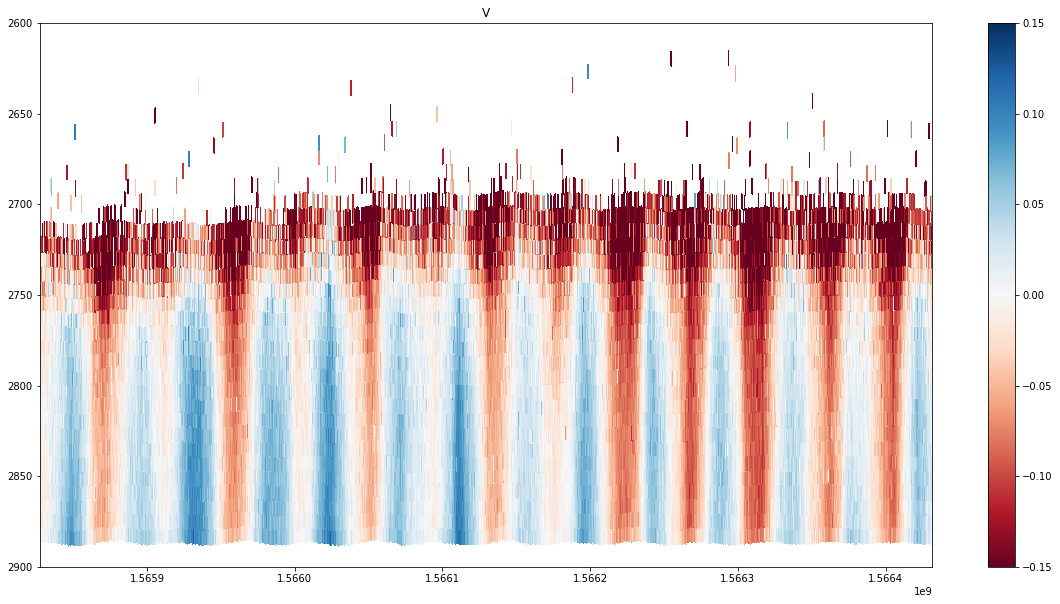

In [9]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.pcolor(dt, bin_depth.T, v_cor.T, cmap='RdBu', vmin=-0.15, vmax=0.15)
plt.title('V')
# set the limits of the plot to the limits of the data
plt.axis([dt.min(), dt.max(), 2600, 2900])
plt.colorbar()
ax = plt.gca()
ax.invert_yaxis()
plt.show()